In [70]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt

In [71]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [72]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [73]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [74]:
ticker='TSLA'

In [75]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [76]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [77]:
dates = pd.to_datetime(df['Date'])

In [78]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [79]:
df_for_training = df[cols].astype(float)

In [80]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [81]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [82]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [83]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [84]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [85]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [86]:
def build_model(hp):
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model=Sequential()
    model.add(LSTM(hp_units,activation='relu',input_shape=(X.shape[1],X.shape[2]),return_sequences=False))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [87]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='lstm_tuning',
                     )

Reloading Tuner from ./lstm_tuning/tuner0.json


In [88]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[stop_early])

In [89]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 202.



Epoch 1/1000
3/3 [==============================] - 1s 90ms/step - loss: 0.0682 - val_loss: 0.1684
Epoch 2/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0587 - val_loss: 0.1519
Epoch 3/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0500 - val_loss: 0.1366
Epoch 4/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0422 - val_loss: 0.1223
Epoch 5/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0352 - val_loss: 0.1089
Epoch 6/1000
3/3 [==============================] - 0s 16ms/step - loss: 0.0290 - val_loss: 0.0965
Epoch 7/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0236 - val_loss: 0.0851
Epoch 8/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0189 - val_loss: 0.0746
Epoch 9/1000
3/3 [==============================] - 0s 17ms/step - loss: 0.0149 - val_loss: 0.0651
Epoch 10/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0116 - val_loss: 0.0564
Epoch 11/

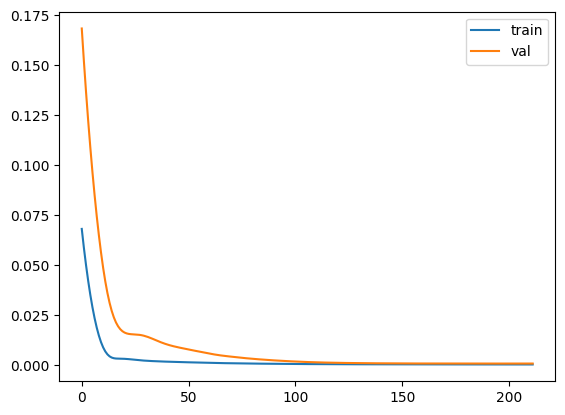

4/4 [==============================] - 0s 5ms/step
train mae: 0.6637405409086785
val mae: 0.4583425940087892


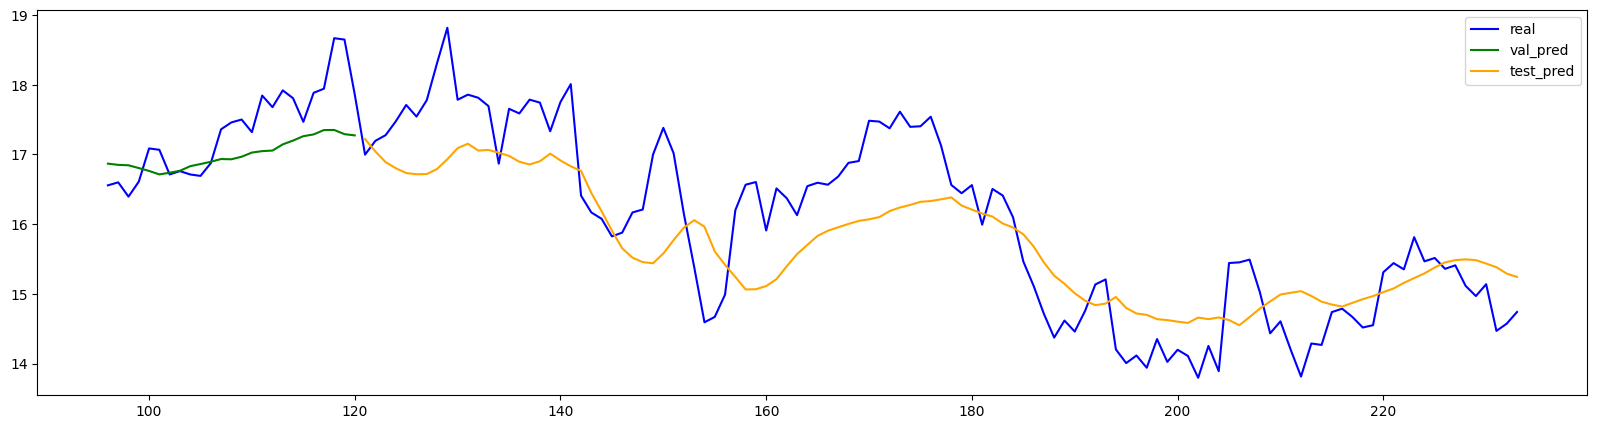

Epoch 1/1000
6/6 [==============================] - 5s 63ms/step - loss: 0.0929 - val_loss: 0.0549
Epoch 2/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.0687 - val_loss: 0.0365
Epoch 3/1000
6/6 [==============================] - 0s 20ms/step - loss: 0.0483 - val_loss: 0.0217
Epoch 4/1000
6/6 [==============================] - 0s 22ms/step - loss: 0.0317 - val_loss: 0.0108
Epoch 5/1000
6/6 [==============================] - 0s 21ms/step - loss: 0.0192 - val_loss: 0.0039
Epoch 6/1000
6/6 [==============================] - 0s 25ms/step - loss: 0.0109 - val_loss: 9.3957e-04
Epoch 7/1000
6/6 [==============================] - 0s 20ms/step - loss: 0.0064 - val_loss: 0.0010
Epoch 8/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 9/1000
6/6 [==============================] - 0s 20ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 10/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch

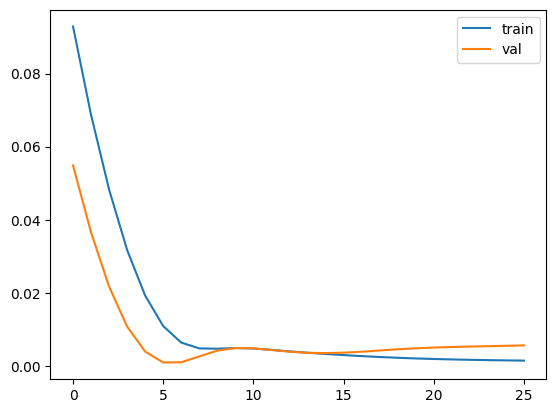

4/4 [==============================] - 0s 4ms/step
train mae: 1.9247095031592445
val mae: 1.3528122301804564


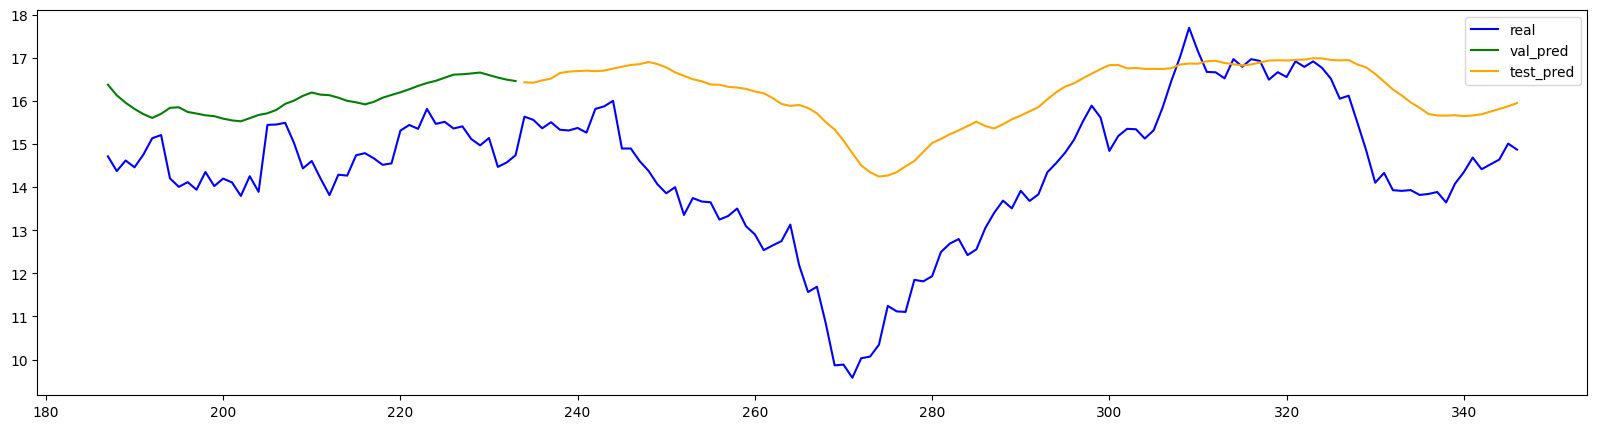

Epoch 1/1000
9/9 [==============================] - 1s 28ms/step - loss: 0.0864 - val_loss: 0.0544
Epoch 2/1000
9/9 [==============================] - 0s 20ms/step - loss: 0.0491 - val_loss: 0.0291
Epoch 3/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0251 - val_loss: 0.0140
Epoch 4/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0123 - val_loss: 0.0072
Epoch 5/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0075 - val_loss: 0.0050
Epoch 6/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 7/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 8/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 9/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 10/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 11/

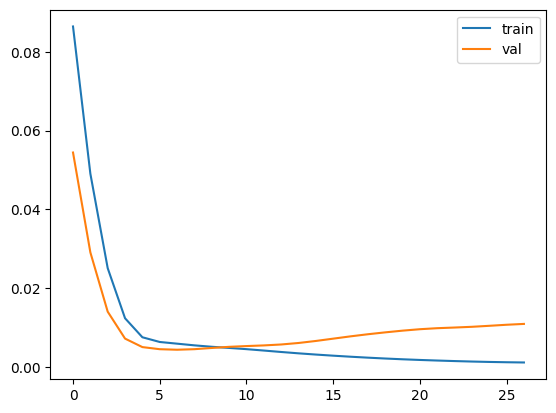

4/4 [==============================] - 0s 4ms/step
train mae: 2.1110026787951988
val mae: 1.8544367127947123


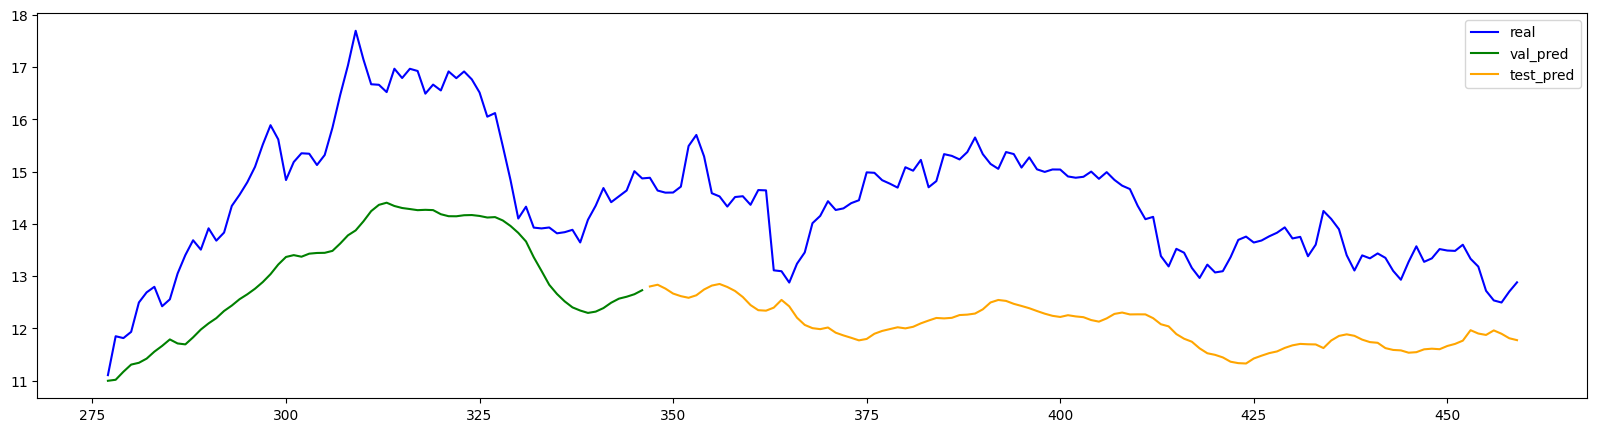

Epoch 1/1000
12/12 [==============================] - 1s 24ms/step - loss: 0.1003 - val_loss: 0.0475
Epoch 2/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.0604 - val_loss: 0.0234
Epoch 3/1000
12/12 [==============================] - 0s 17ms/step - loss: 0.0335 - val_loss: 0.0093
Epoch 4/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.0165 - val_loss: 0.0032
Epoch 5/1000
12/12 [==============================] - 0s 16ms/step - loss: 0.0077 - val_loss: 0.0027
Epoch 6/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 7/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 8/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 10/1000
12/12 [==============================] - 0s 15ms/step - loss: 0.0030 - val_lo

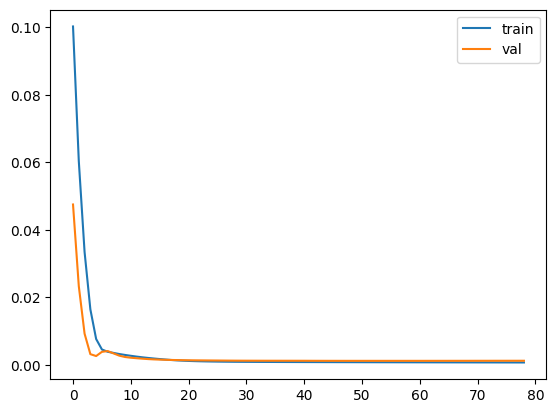

4/4 [==============================] - 0s 4ms/step
train mae: 0.5189180427181278
val mae: 0.5483197393831999


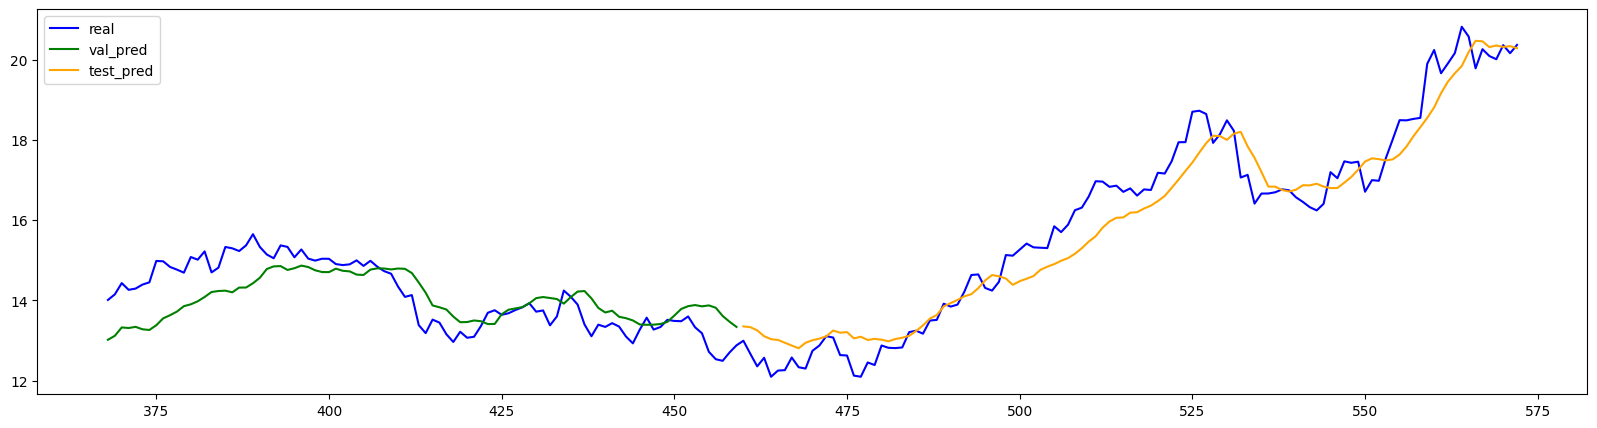

Epoch 1/1000
15/15 [==============================] - 1s 21ms/step - loss: 0.0378 - val_loss: 0.0490
Epoch 2/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0145 - val_loss: 0.0221
Epoch 3/1000
15/15 [==============================] - 0s 15ms/step - loss: 0.0069 - val_loss: 0.0144
Epoch 4/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0057 - val_loss: 0.0134
Epoch 5/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0139
Epoch 6/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0143
Epoch 7/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0043 - val_loss: 0.0140
Epoch 8/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0135
Epoch 9/1000
15/15 [==============================] - 0s 14ms/step - loss: 0.0033 - val_loss: 0.0130
Epoch 10/1000
15/15 [==============================] - 0s 15ms/step - loss: 0.0029 - val_lo

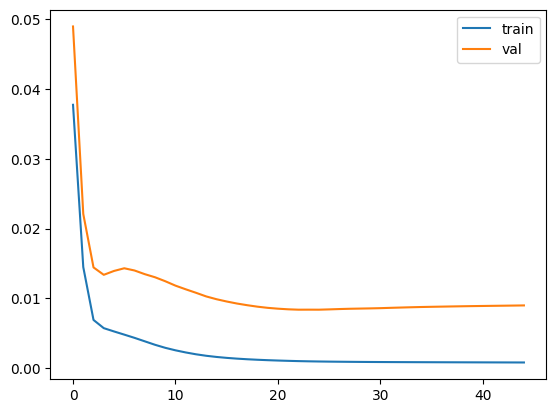

4/4 [==============================] - 0s 4ms/step
train mae: 3.3956910566190195
val mae: 1.6162009585051165


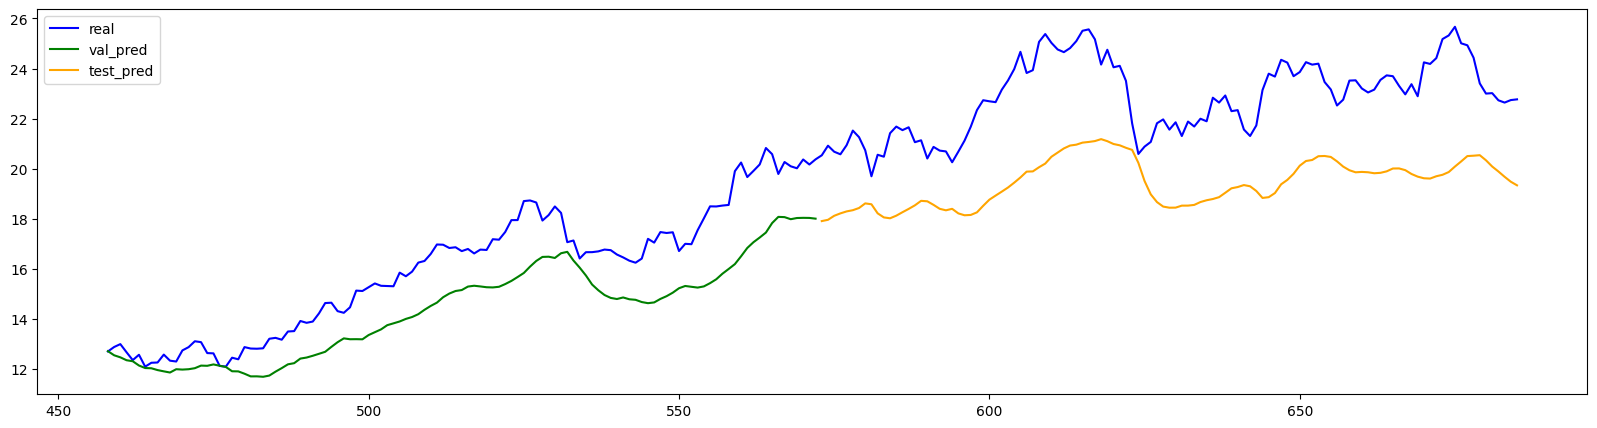

Epoch 1/1000
18/18 [==============================] - 1s 19ms/step - loss: 0.0784 - val_loss: 0.3426
Epoch 2/1000
18/18 [==============================] - 0s 15ms/step - loss: 0.0347 - val_loss: 0.2050
Epoch 3/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0140 - val_loss: 0.1203
Epoch 4/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0074 - val_loss: 0.0805
Epoch 5/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0702
Epoch 6/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0056 - val_loss: 0.0690
Epoch 7/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 0.0665
Epoch 8/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0619
Epoch 9/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0044 - val_loss: 0.0574
Epoch 10/1000
18/18 [==============================] - 0s 14ms/step - loss: 0.0041 - val_lo

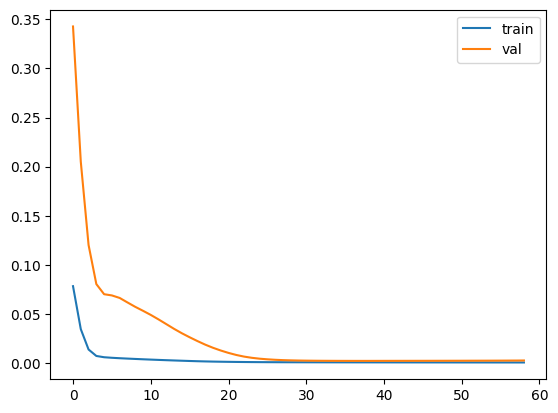

4/4 [==============================] - 0s 5ms/step
train mae: 0.7088073882343662
val mae: 0.7989290142901876


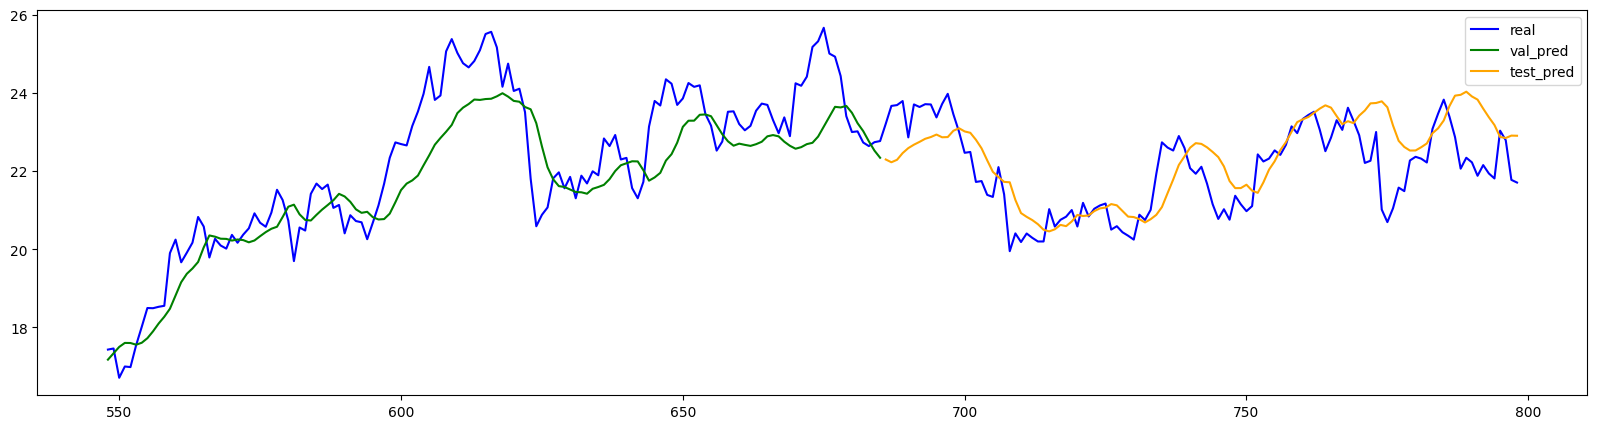

Epoch 1/1000
20/20 [==============================] - 1s 18ms/step - loss: 0.0454 - val_loss: 0.1315
Epoch 2/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0119 - val_loss: 0.0448
Epoch 3/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0.0244
Epoch 4/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0079 - val_loss: 0.0200
Epoch 5/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.0062 - val_loss: 0.0143
Epoch 6/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0091
Epoch 7/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0061
Epoch 8/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 9/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 10/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.0021 - val_lo

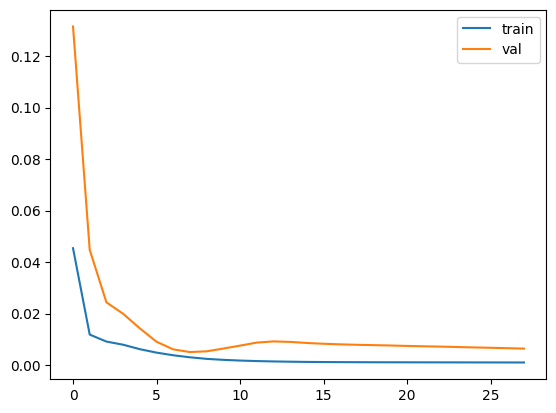

4/4 [==============================] - 0s 4ms/step
train mae: 2.724434064848503
val mae: 1.2479476717033386


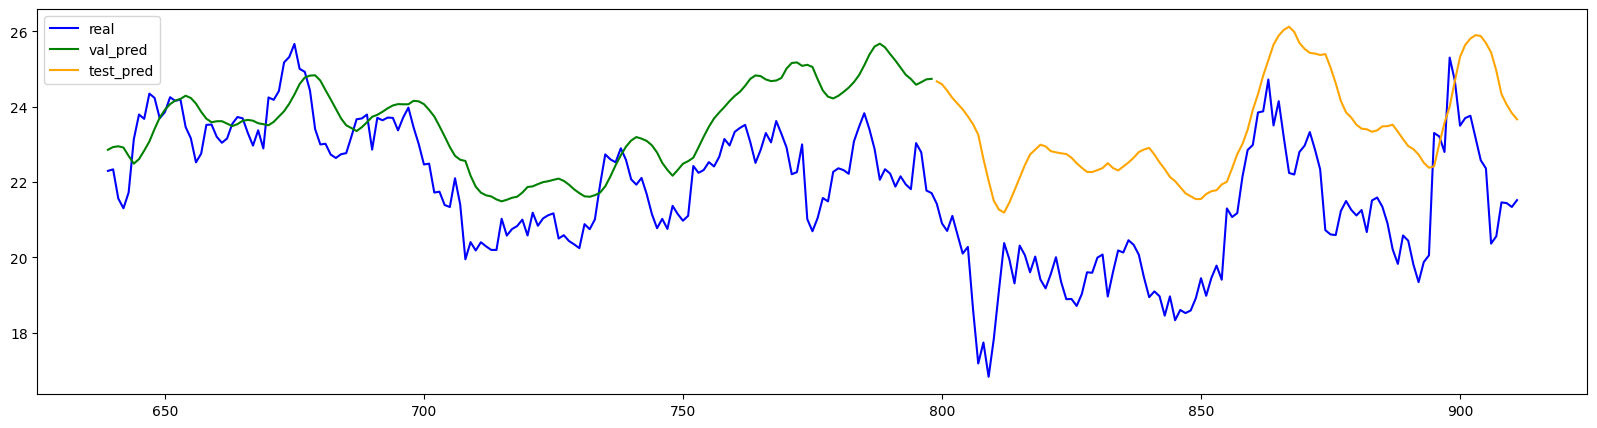

Epoch 1/1000
23/23 [==============================] - 1s 17ms/step - loss: 0.1077 - val_loss: 0.1992
Epoch 2/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0347 - val_loss: 0.0578
Epoch 3/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0150 - val_loss: 0.0142
Epoch 4/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0128 - val_loss: 0.0069
Epoch 5/1000
23/23 [==============================] - 0s 13ms/step - loss: 0.0104 - val_loss: 0.0057
Epoch 6/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 7/1000
23/23 [==============================] - 0s 13ms/step - loss: 0.0056 - val_loss: 0.0077
Epoch 8/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0098
Epoch 9/1000
23/23 [==============================] - 0s 13ms/step - loss: 0.0031 - val_loss: 0.0117
Epoch 10/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0025 - val_lo

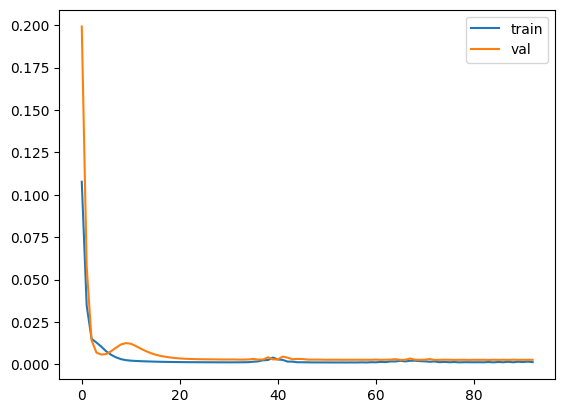

4/4 [==============================] - 0s 4ms/step
train mae: 0.9171958421382398
val mae: 0.7480386580010085


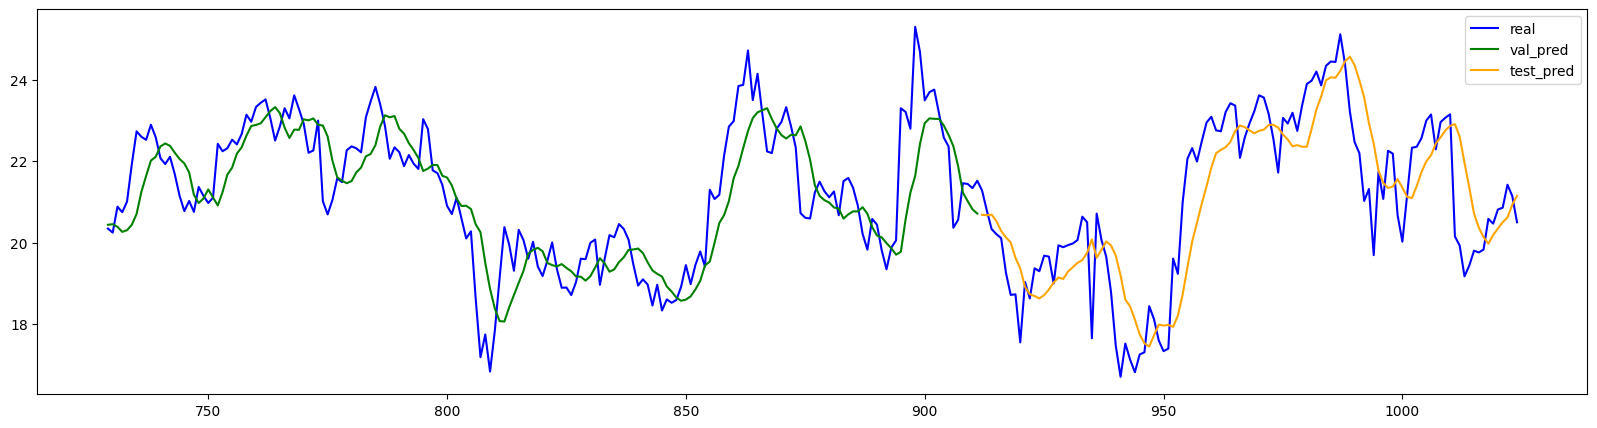

Epoch 1/1000
26/26 [==============================] - 1s 17ms/step - loss: 0.1943 - val_loss: 0.0940
Epoch 2/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0444 - val_loss: 0.0122
Epoch 3/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0096 - val_loss: 0.0735
Epoch 4/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0076 - val_loss: 0.0644
Epoch 5/1000
26/26 [==============================] - 0s 13ms/step - loss: 0.0067 - val_loss: 0.0564
Epoch 6/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0059 - val_loss: 0.0540
Epoch 7/1000
26/26 [==============================] - 0s 13ms/step - loss: 0.0051 - val_loss: 0.0487
Epoch 8/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0044 - val_loss: 0.0435
Epoch 9/1000
26/26 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0381
Epoch 10/1000
26/26 [==============================] - 0s 13ms/step - loss: 0.0033 - val_lo

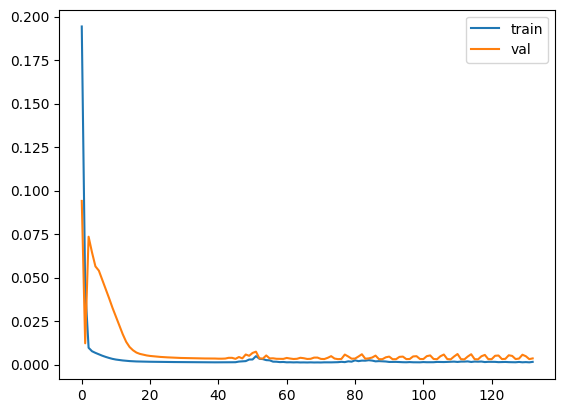

4/4 [==============================] - 0s 4ms/step
train mae: 0.9816529000946315
val mae: 0.9016165196318836


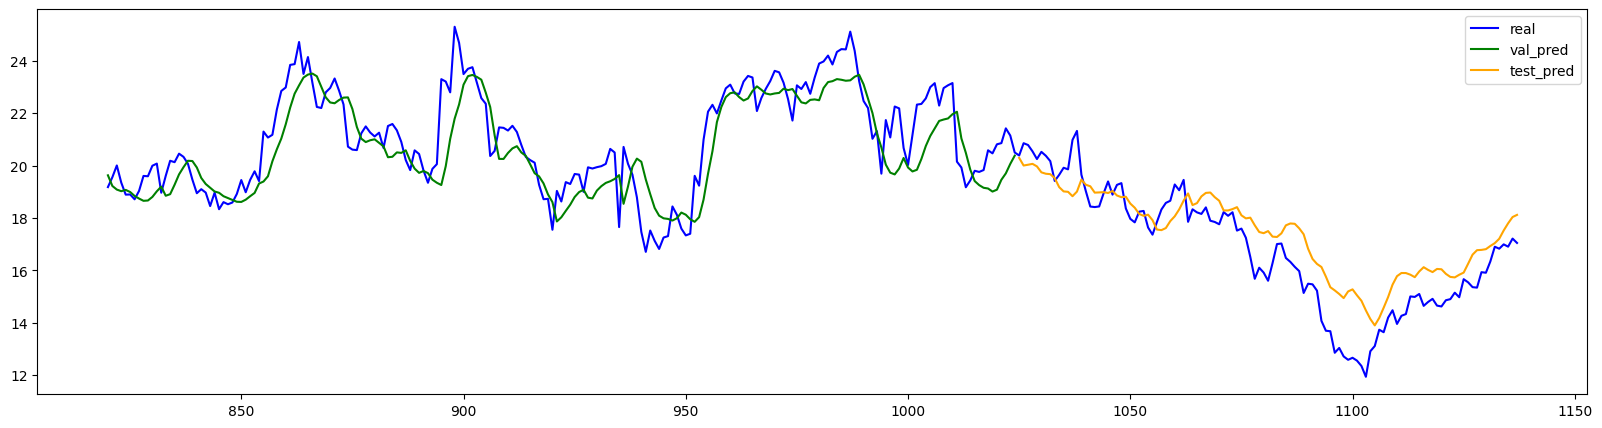

Epoch 1/1000
29/29 [==============================] - 1s 16ms/step - loss: 0.0848 - val_loss: 0.0157
Epoch 2/1000
29/29 [==============================] - 0s 16ms/step - loss: 0.0134 - val_loss: 0.0774
Epoch 3/1000
29/29 [==============================] - 0s 15ms/step - loss: 0.0095 - val_loss: 0.0589
Epoch 4/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0475
Epoch 5/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0069 - val_loss: 0.0402
Epoch 6/1000
29/29 [==============================] - 0s 13ms/step - loss: 0.0056 - val_loss: 0.0311
Epoch 7/1000
29/29 [==============================] - 0s 13ms/step - loss: 0.0044 - val_loss: 0.0243
Epoch 8/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0185
Epoch 9/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0141
Epoch 10/1000
29/29 [==============================] - 0s 14ms/step - loss: 0.0024 - val_lo

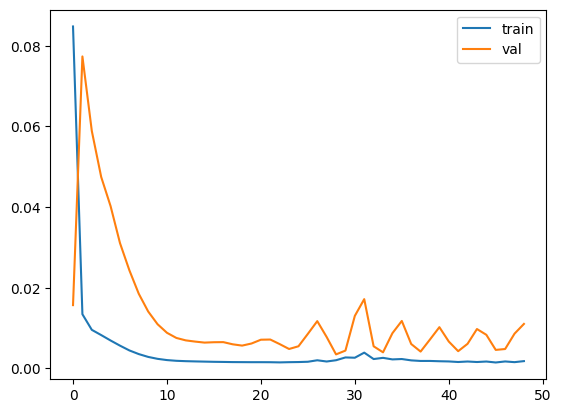

4/4 [==============================] - 0s 3ms/step
train mae: 1.5219416109413888
val mae: 1.6661377884928386


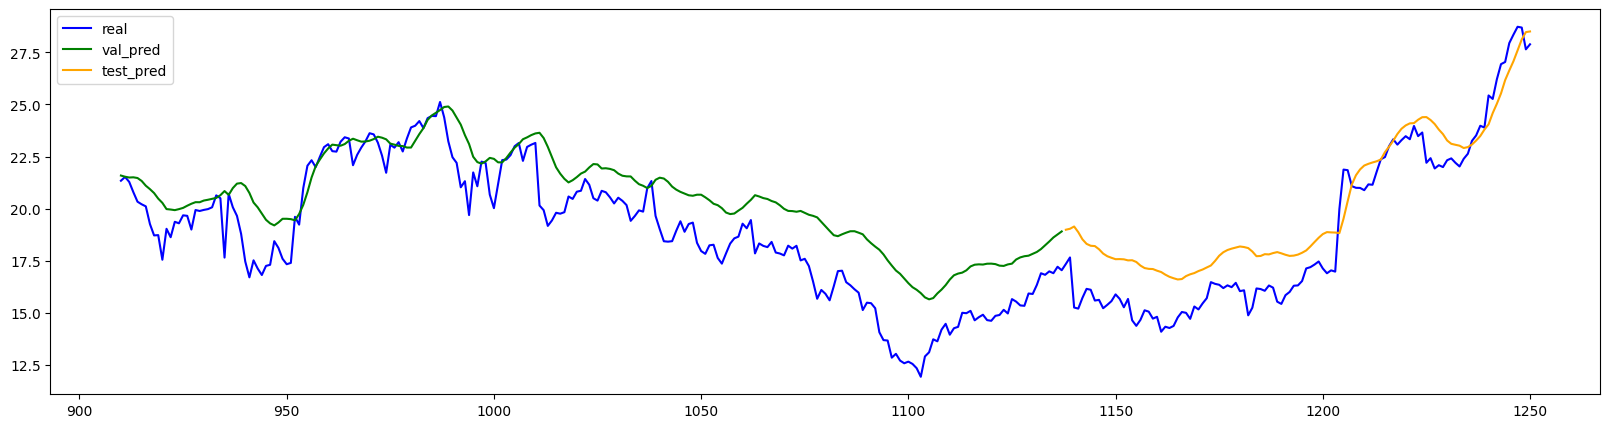

In [90]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=np.mean(np.abs(pred-y_test))
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=np.mean(np.abs(val_pred-y_val))
    v_maes.append(v_mae)
    print('val mae:',v_mae)

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()

In [91]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 202)               177760    
                                                                 
 dense_39 (Dense)            (None, 1)                 203       
                                                                 
Total params: 177963 (695.17 KB)
Trainable params: 177963 (695.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [92]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Average MAE in testing: 1.54680936284574
Average MAE in validation: 1.1192781886991532
